We can actually use our interval estimates to approximate all manner of Hardware properties such as:

* On CPU time of operations (e.g. some reads are slower than others)
* Request size distributions (e.g. some reads are bigger than others)
* Disk latency (e.g. some disks are faster or more consistent than others)

For a concrete example let's model a m5d drive which we [model](https://github.com/Netflix-Skunkworks/service-capacity-modeling/blob/dd1fb503b4505327d1cf14d2d614c0e796bb8f05/service_capacity_modeling/hardware/profiles/shapes/aws.json#L98) with an io latency distribution. Data for comparision comes from using `biosnoop` and [`histogram.py`](https://github.com/bitly/data_hacks/blob/master/data_hacks/histogram.py) on a Cassandra server (the threads that are servicing reads are from the SharedPool).

```bash
$ sudo /usr/share/bcc/tools/biosnoop > ios
$ grep SharedPool ios | tr -s ' ' | cut -f 8  -d ' ' > io_lat
$ cat io_lat | histogram.py -l -p
# NumSamples = 107517; Min = 0.06; Max = 2.43
# Mean = 0.118898; Variance = 0.002304; SD = 0.048005; Median 0.100000
# each ∎ represents a count of 569
    0.0600 -     0.0623 [    94]:  (0.09%)
    0.0623 -     0.0670 [     0]:  (0.00%)
    0.0670 -     0.0762 [   505]:  (0.47%)
    0.0762 -     0.0948 [ 33459]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎ (31.12%)
    0.0948 -     0.1318 [ 42706]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎ (39.72%)
    0.1318 -     0.2060 [ 29154]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎ (27.12%)
    0.2060 -     0.3542 [   994]: ∎ (0.92%)
    0.3542 -     0.6508 [   523]:  (0.49%)
    0.6508 -     1.2438 [    77]:  (0.07%)
    1.2438 -     2.4300 [     5]:  (0.00%)
```

In [1]:
from service_capacity_modeling.stats import gamma_for_interval
from service_capacity_modeling.interface import FixedInterval, Interval

import matplotlib.pyplot as plt
import numpy as np
import glob

In [2]:
data = {}
for io_data in glob.glob("io_latency/*"):
    real_data = np.loadtxt(io_data)
    real_interval = np.percentile(real_data, [5, 50, 95])

    read_io_latency = FixedInterval(
        low=round(real_interval[0], 2),
        mid=round(np.mean(real_data), 4),
        high=round(real_interval[2], 2),
        confidence=0.9
    )

    io_gamma = gamma_for_interval(read_io_latency)
    print(f"\nAnalyzing {io_data}")
    print(f"{real_interval} with mean {np.mean(real_data)} and range [{min(real_data)}, {max(real_data)}]")
    print(read_io_latency.json(exclude_unset=True))
    data[io_data] = {}
    data[io_data]["real"] = real_data
    data[io_data]["interval"] = read_io_latency.json(exclude_unset=True)
    data[io_data]["dist"] = io_gamma


Analyzing io_latency/m5d_cass_io_lat
[0.08 0.1  0.18] with mean 0.11889756968665424 and range [0.06, 2.43]
{"low": 0.08, "mid": 0.1189, "high": 0.18, "confidence": 0.9}

Analyzing io_latency/gp2_cass_io_lat
[0.559 1.01  1.611] with mean 1.0578129117259552 and range [0.31, 7.88]
{"low": 0.56, "mid": 1.0578, "high": 1.61, "confidence": 0.9}

Analyzing io_latency/i3_cass_io_lat
[0.11 0.16 0.21] with mean 0.17415579742736348 and range [0.07, 4.18]
{"low": 0.11, "mid": 0.1742, "high": 0.21, "confidence": 0.9}


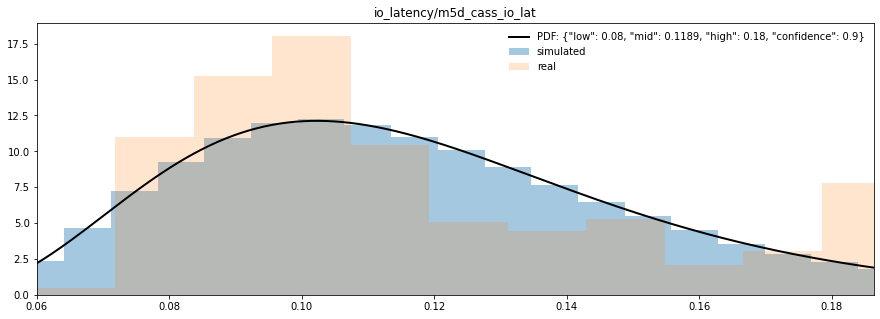

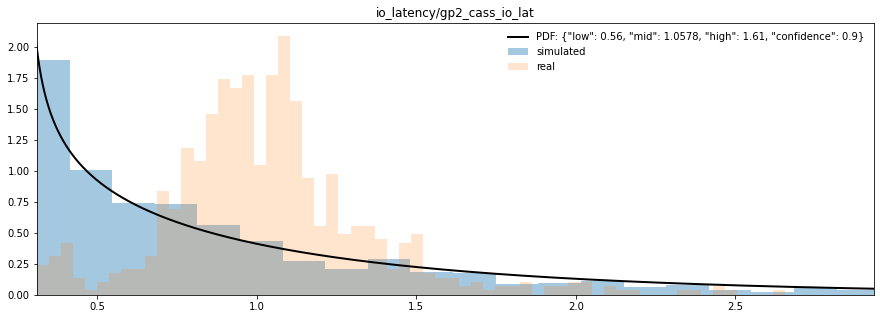

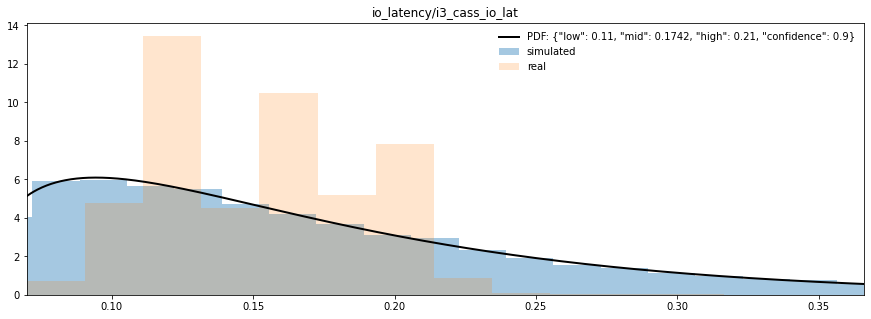

In [3]:
for sample in data:
    io_gamma = data[sample]["dist"]
    real_data = data[sample]["real"]
    fig, ax = plt.subplots(1, 1, figsize=(15,5))

    x = np.linspace(min(real_data), max(real_data), 10000)

    ax.plot(x, io_gamma.pdf(x), 'k-', lw=2, label=f"PDF: {data[sample]['interval']}")

    r = io_gamma.rvs(size=len(real_data))
    ax.hist(r, density=True, histtype='stepfilled', alpha=0.4, bins=50, label="simulated")
    ax.hist(real_data, density=True, histtype='stepfilled', bins=200, alpha=0.2, label="real")

    ax.legend(loc='best', frameon=False)
    ax.set_title(sample)
    ax.set_xlim(min(real_data), io_gamma.ppf(0.95))

    plt.show()

In [4]:
from scipy.stats import kstest
for sample in data:
    io_gamma = data[sample]["dist"]
    real_data = data[sample]["real"]
    r = io_gamma.rvs(size=len(real_data))
    print(sample, ":", kstest(r, real_data))

io_latency/m5d_cass_io_lat : KstestResult(statistic=0.19300203688718998, pvalue=0.0)
io_latency/gp2_cass_io_lat : KstestResult(statistic=0.40711462450592883, pvalue=1.2236231272651964e-56)
io_latency/i3_cass_io_lat : KstestResult(statistic=0.2467392282090492, pvalue=1.669974154951776e-298)


# Adjustments
There are some odd bi-modalities going on here, so to compensate we can shift low and high around for our actual
hardware model to better fit the data.

io_latency/gp2_cass_io_lat : KstestResult(statistic=0.1370223978919631, pvalue=1.2496589716028753e-06)


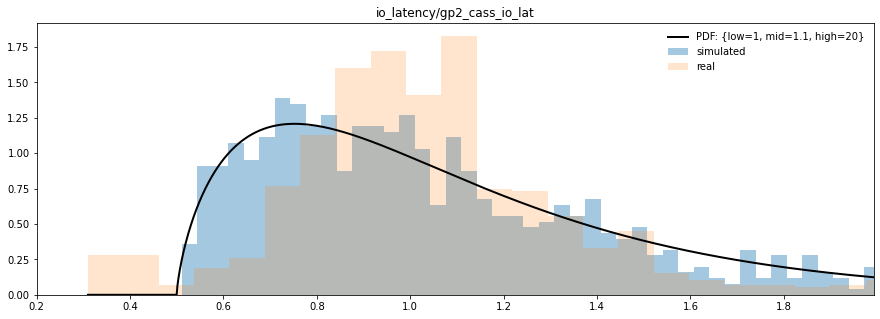

In [5]:
sample = "io_latency/gp2_cass_io_lat"

io_gamma = gamma_for_interval(FixedInterval(low=1, mid=1.1, high=20, confidence=0.9))

real_data = data[sample]["real"]
fig, ax = plt.subplots(1, 1, figsize=(15,5))

x = np.linspace(min(real_data), max(real_data), 10000)

ax.plot(x, io_gamma.pdf(x), 'k-', lw=2, label="PDF: {low=1, mid=1.1, high=20}")

r = io_gamma.rvs(size=len(real_data))
ax.hist(r, density=True, histtype='stepfilled', alpha=0.4, bins=100, label="simulated")
ax.hist(real_data, density=True, histtype='stepfilled', bins=100, alpha=0.2, label="real")

ax.legend(loc='best', frameon=False)
ax.set_title(sample)
ax.set_xlim(0.2, io_gamma.ppf(0.95))

r = io_gamma.rvs(size=len(real_data))
print(sample, ":", kstest(r, real_data))
plt.show()

0.11889756968665424
io_latency/m5d_cass_io_lat : KstestResult(statistic=0.21266404382562754, pvalue=0.0)


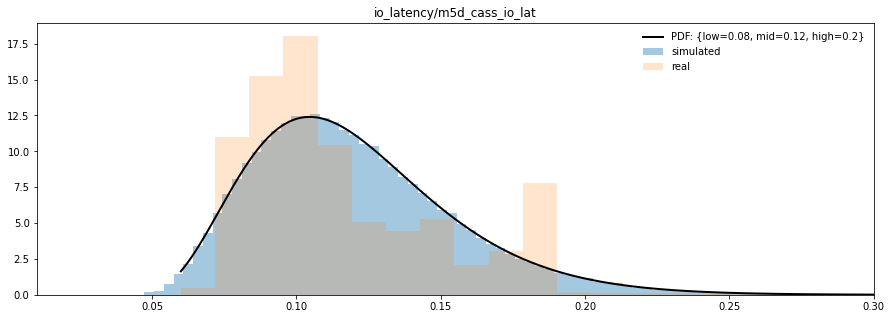

In [6]:
sample = "io_latency/m5d_cass_io_lat"

io_gamma = gamma_for_interval(FixedInterval(low=0.08, mid=0.12, high=0.2, confidence=0.9))

real_data = data[sample]["real"]
fig, ax = plt.subplots(1, 1, figsize=(15,5))

x = np.linspace(min(real_data), max(real_data), 10000)

ax.plot(x, io_gamma.pdf(x), 'k-', lw=2, label="PDF: {low=0.08, mid=0.12, high=0.2}")

r = io_gamma.rvs(size=len(real_data))
ax.hist(r, density=True, histtype='stepfilled', alpha=0.4, bins=100, label="simulated")
ax.hist(real_data, density=True, histtype='stepfilled', bins=200, alpha=0.2, label="real")

ax.legend(loc='best', frameon=False)
ax.set_title(sample)
ax.set_xlim(0.01, 0.3)
print(np.mean(real_data))

r = io_gamma.rvs(size=len(real_data))
print(sample, ":", kstest(r, real_data))
plt.show()

0.17415579742736348
io_latency/i3_cass_io_lat : KstestResult(statistic=0.24934784564180978, pvalue=6.237186079979724e-305)


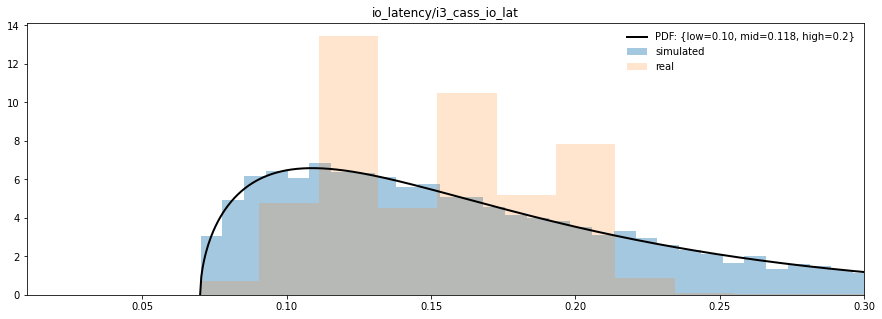

In [7]:
sample = "io_latency/i3_cass_io_lat"

io_gamma = gamma_for_interval(FixedInterval(low=0.14, mid=0.18, high=0.25, confidence=0.9))

real_data = data[sample]["real"]
fig, ax = plt.subplots(1, 1, figsize=(15,5))

x = np.linspace(min(real_data), max(real_data), 10000)

ax.plot(x, io_gamma.pdf(x), 'k-', lw=2, label="PDF: {low=0.10, mid=0.118, high=0.2}")

r = io_gamma.rvs(size=len(real_data))
ax.hist(r, density=True, histtype='stepfilled', alpha=0.4, bins=100, label="simulated")
ax.hist(real_data, density=True, histtype='stepfilled', bins=200, alpha=0.2, label="real")

ax.legend(loc='best', frameon=False)
ax.set_title(sample)
ax.set_xlim(0.01, 0.3)
print(np.mean(real_data))

r = io_gamma.rvs(size=len(real_data))
print(sample, ":", kstest(r, real_data))
plt.show()